# Question 2

In [117]:
import numpy as np
import gym
import math
import random
import matplotlib.pyplot as plt

In [118]:
random.seed(0) # for hash function
np.random.seed(0)
seeds = np.random.randint(1, 5562, 10) # create the list of seeds for each run

In [119]:
seeds

array([2733, 2608, 1654, 3265, 4932, 4860, 1034, 4374, 3469,  706])

In [120]:
env = gym.make("MountainCar-v0")
env.seed(0) # making steps reproducible

[0]

In [121]:
num_tilings = 8 # number of tilings to use
num_bins = [8] * len(env.observation_space.high) # nunber of bins in each tiling
num_actions = env.action_space.n # number of actions

total_size = num_tilings * np.prod(num_bins) * num_actions # total nunber of unique indexes needed for each combination

In [122]:
scales = [ num_tilings / (env.observation_space.high[i] - env.observation_space.low[i]) for i in range(len(env.observation_space.high))]

In [123]:
# This is a re-implementation of the function given in : https://github.com/kamenbliznashki/sutton_barto/blob/master/tiles3.py
def get_tilings_index_array(num_indices = total_size, num_tilings = num_tilings , states = [], scales = scales, action = None):
    hashed_indices = []
    scaled_states = np.multiply(states, scales)
#     print(scaled_states)
    for i in range(num_tilings):
        indices = [i] # the first element is for creating a unique list for each tiling
        for c, ss in enumerate(scaled_states):
            ssm = math.floor(ss * num_tilings)
            indices.append(math.floor( (ssm + i*(1+2*c)) / num_tilings ))
        indices.append(action) # the last element is for creating a unique list for each state action pair
        hashed_indices.append(hash(tuple(indices)) % num_indices)
    return hashed_indices

In [124]:
env._max_episode_steps = 2000 # Set max episode steps to a high number

In [125]:
epsilon = 0.1 # epsilon for exploration

In [81]:
alphas = np.linspace(0,1, num = 6)
alphas /= num_tilings
alphas = alphas[1:]
lambdas = np.linspace(0,1, num = 6)
lambdas = lambdas[1:-1]
data = np.zeros((len(lambdas),len(alphas), len(seeds)))
gamma = 1.0
num_episodes = 1000

In [82]:
alphas

array([0.025, 0.05 , 0.075, 0.1  , 0.125])

In [83]:
lambdas

array([0.2, 0.4, 0.6, 0.8])

In [126]:
def get_action(state, weights):
    # act in a epsilon-greedy manner
    if np.random.rand() < epsilon: # get a random number and if is less than epsilon, choose a random action
        action = np.random.choice(np.arange(num_actions))
    else: # otherwise choose the greedy action ( the state action pair with the highest value given current weights )
        features = [get_tilings_index_array(states = state, action = a) for a in np.arange(num_actions)]
        action = np.argmax([np.sum(weights[f]) for f in features])
    return action

In [85]:
data = np.zeros((len(lambdas), len(alphas), len(seeds)))

In [ ]:
# for each lambda
for l, lambd in enumerate(lambdas):
    # for each alpha
    for al, alpha in enumerate(alphas): 
        # for each seed
        for run in range(0, len(seeds)):            
#             set the seed for each run

            random.seed(seeds[run])
            np.random.seed(seeds[run])
            
            # initialize the weight vector and trace vector
            w = np.zeros(total_size)
            z = np.zeros(total_size)

            # do 1000 episodes of TD(lambda)
            for episode in range(num_episodes + 1):
                # get the initial state
                s = env.reset()

                # set trace vector to zero
                z = np.zeros(total_size)
                
                # Get action a
                a = get_action(s,w)
                
                steps = 0

                while(1):
                    
                    # Take action and observe reward and next state
                    s_prime, r, done, _ = env.step(a)
                    steps += 1
                    
                    delta = r
                    
                    indices = get_tilings_index_array(states = s , action = a)
                    
                    q_s = np.sum(w[indices])
                    delta -= q_s
                    z[indices] = 1
                    
                    if done == True:
                        w += alpha*delta*z
                        break

                    # Choose A' 
                    a_prime = get_action(s_prime,w)

                    # Get features for s' , a'
                    indices_prime = get_tilings_index_array(states = s_prime , action = a_prime)
                    q_new = np.sum(w[indices_prime])

                    delta += gamma*q_new
                    w += alpha*delta*z
                    z = gamma*lambd*z

                    s = s_prime
                    a = a_prime
                    
                if ( episode == num_episodes ):
                    data[l,al,run] = steps
                    print(np.count_nonzero(data))

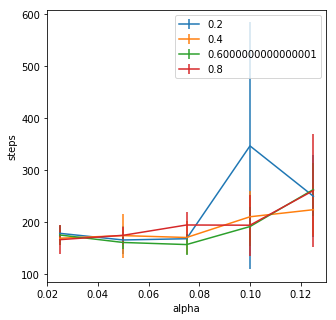

In [91]:
f, axes = plt.subplots(1, 1, figsize=(5, 5))

# plt.ylim(top=1) #ymax is your value
# plt.ylim(bottom=0) #ymin is your value
for i in range(0, len(lambdas), 1):
    means = np.mean(data[i,:,:], axis  = 1)
#     print(means)
    std = np.std(data[i,:,:], axis  = 1)
#     print(std) 
#     axes.plot(alphas, means)
#     axes.fill_between(alphas, means-std, means+std,  alpha = 0.3)
    axes.errorbar(alphas, means, yerr=std)
# plt.ylim(top=1)

axes.legend(lambdas)
axes.set_xlabel('alpha')
axes.set_ylabel('steps')
plt.show()

In [94]:
alphas = np.linspace(0,1.5, num = 11)
alphas /= num_tilings
alphas = alphas[1:-1]
lambdas = np.linspace(0,1, num = 6)
lambdas = lambdas[1:-1]
gamma = 1.0
num_episodes = 1000

In [95]:
alphas

array([0.01875, 0.0375 , 0.05625, 0.075  , 0.09375, 0.1125 , 0.13125,
       0.15   , 0.16875])

In [100]:
data2 = np.zeros((len(lambdas), len(alphas), len(seeds)))

In [ ]:
# for each lambda
for l, lambd in enumerate(lambdas):
    # for each alpha
    for al, alpha in enumerate(alphas): 
        # for each seed
        for run in range(0, len(seeds)):            
#             set the seed for each run

            random.seed(seeds[run])
            np.random.seed(seeds[run])
            
            # initialize the weight vector and trace vector
            w = np.zeros(total_size)
            z = np.zeros(total_size)

            # do 1000 episodes of TD(lambda)
            for episode in range(50 + 1):
                # get the initial state
                s = env.reset()

                # set trace vector to zero
                z = np.zeros(total_size)
                
                # Get action a
                a = get_action(s,w)
                
                steps = 0

                while(1):
                    
                    # Take action and observe reward and next state
                    s_prime, r, done, _ = env.step(a)
                    steps += 1
                    
                    delta = r
                    
                    indices = get_tilings_index_array(states = s , action = a)
                    
                    q_s = np.sum(w[indices])
                    delta -= q_s
                    z[indices] = 1
                    
                    if done == True:
                        w += alpha*delta*z
                        break

                    # Choose A' 
                    a_prime = get_action(s_prime,w)

                    # Get features for s' , a'
                    indices_prime = get_tilings_index_array(states = s_prime , action = a_prime)
                    q_new = np.sum(w[indices_prime])

                    delta += gamma*q_new
                    w += alpha*delta*z
                    z = gamma*lambd*z

                    s = s_prime
                    a = a_prime
                    
                if ( episode == 50 ):
                    data2[l,al,run] = steps
                    print(np.count_nonzero(data2))

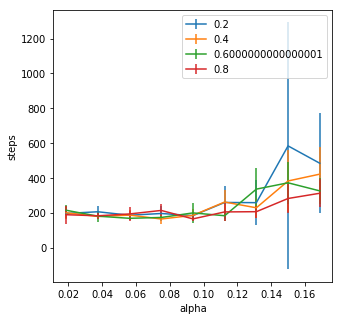

In [102]:
f, axes = plt.subplots(1, 1, figsize=(5, 5))

# plt.ylim(top=1) #ymax is your value
# plt.ylim(bottom=0) #ymin is your value
for i in range(0, len(lambdas), 1):
    means = np.mean(data2[i,:,:], axis  = 1)
#     print(means)
    std = np.std(data2[i,:,:], axis  = 1)
#     print(std) 
#     axes.plot(alphas, means)
#     axes.fill_between(alphas, means-std, means+std,  alpha = 0.3)
    axes.errorbar(alphas, means, yerr=std)
# plt.ylim(top=1)

axes.legend(lambdas)
axes.set_xlabel('alpha')
axes.set_ylabel('steps')
plt.show()

In [146]:
alphas = np.array([0.0, 0.2, 0.6, 1, 1.4])
alphas /= num_tilings
lambdas = [0.0, 0.6, 0.9]
gamma = 1.0
num_episodes = 50

In [147]:
alphas

array([0.   , 0.025, 0.075, 0.125, 0.175])

In [148]:
data3 = np.zeros((len(lambdas), len(alphas), len(seeds)))

In [ ]:
# for each lambda
for l, lambd in enumerate(lambdas):
    # for each alpha
    for al, alpha in enumerate(alphas): 
        # for each seed
        for run in range(0, len(seeds)):            
#             set the seed for each run

            random.seed(seeds[run])
            np.random.seed(seeds[run])
            
            # initialize the weight vector and trace vector
            w = np.zeros(total_size)
            z = np.zeros(total_size)

            # do 1000 episodes of TD(lambda)
            for episode in range(num_episodes + 1):
                # get the initial state
                s = env.reset()

                # set trace vector to zero
                z = np.zeros(total_size)
                
                # Get action a
                a = get_action(s,w)
                
                steps = 0

                while(1):
                    
                    # Take action and observe reward and next state
                    s_prime, r, done, _ = env.step(a)
                    steps += 1
                    
                    delta = r
                    
                    indices = get_tilings_index_array(states = s , action = a)
                    
                    q_s = np.sum(w[indices])
                    delta -= q_s
                    z[indices] = 1
                    
                    if done == True:
                        w += alpha*delta*z
                        break

                    # Choose A' 
                    a_prime = get_action(s_prime,w)

                    # Get features for s' , a'
                    indices_prime = get_tilings_index_array(states = s_prime , action = a_prime)
                    q_new = np.sum(w[indices_prime])

                    delta += gamma*q_new
                    w += alpha*delta*z
                    z = gamma*lambd*z

                    s = s_prime
                    a = a_prime
                    
                if ( episode == num_episodes ):
                    data3[l,al,run] = steps
                    print(np.count_nonzero(data3))

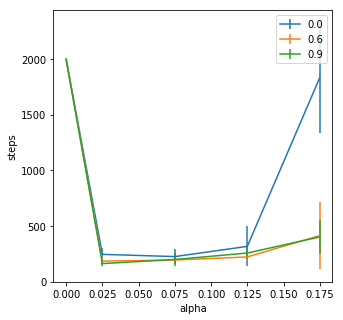

In [151]:
f, axes = plt.subplots(1, 1, figsize=(5, 5))

for i in range(0, len(lambdas), 1):
    means = np.mean(data3[i,:,:], axis  = 1)
    std = np.std(data3[i,:,:], axis  = 1)
    axes.errorbar(alphas, means, yerr=std)

axes.legend(lambdas)
axes.set_xlabel('alpha')
axes.set_ylabel('steps')
plt.show()

In [128]:
alphas = np.array([0.0, 0.2, 0.6, 1, 1.4])
alphas /= num_tilings
lambdas = [0.0, 0.6, 0.9]
gamma = 1.0
num_episodes = 50

In [129]:
alphas

array([0.   , 0.025, 0.075, 0.125, 0.175])

In [130]:
data4 = np.zeros((len(lambdas), len(alphas), len(seeds)))

In [ ]:
# for each lambda
for l, lambd in enumerate(lambdas):
    # for each alpha
    for al, alpha in enumerate(alphas): 
        # for each seed
        for run in range(0, len(seeds)):            
#             set the seed for each run

            random.seed(seeds[run])
            np.random.seed(seeds[run])
            
            # initialize the weight vector and trace vector
            w = np.zeros(total_size)
            z = np.zeros(total_size)

            # do 1000 episodes of TD(lambda)
            for episode in range(num_episodes):
                # get the initial state
                s = env.reset()

                # set trace vector to zero
                z = np.zeros(total_size)
                
                # Get action a
                a = get_action(s,w)
                
                steps = 0

                while(1):
                    
                    # Take action and observe reward and next state
                    s_prime, r, done, _ = env.step(a)
                    steps += 1
                    
                    delta = r
                    
                    indices = get_tilings_index_array(states = s , action = a)
                    
                    q_s = np.sum(w[indices])
                    delta -= q_s
                    z[indices] = 1
                    
                    if done == True:
                        w += alpha*delta*z
                        break

                    # Choose A' 
                    a_prime = get_action(s_prime,w)

                    # Get features for s' , a'
                    indices_prime = get_tilings_index_array(states = s_prime , action = a_prime)
                    q_new = np.sum(w[indices_prime])

                    delta += gamma*q_new
                    w += alpha*delta*z
                    z = gamma*lambd*z

                    s = s_prime
                    a = a_prime
                    
            # test without changing weights
            s = env.reset()
            a = get_action(s,w)
            steps = 0
            while(1):
                s_prime, r, done, _ = env.step(a)
                steps += 1
                if done == True:
                    break
                a_prime = get_action(s_prime,w)
                s = s_prime
                a = a_prime
                
            data4[l,al,run] = steps
            print(np.count_nonzero(data4))

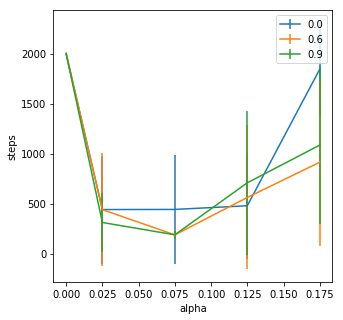

In [132]:
f, axes = plt.subplots(1, 1, figsize=(5, 5))

# plt.ylim(top=1) #ymax is your value
# plt.ylim(bottom=0) #ymin is your value
for i in range(0, len(lambdas), 1):
    means = np.mean(data4[i,:,:], axis  = 1)
    std = np.std(data4[i,:,:], axis  = 1)
    axes.errorbar(alphas, means, yerr=std)

axes.legend(lambdas)
axes.set_xlabel('alpha')
axes.set_ylabel('steps')
plt.show()

In [133]:
def get_action_greedy(state, weights):
    features = [get_tilings_index_array(states = state, action = a) for a in np.arange(num_actions)]
    action = np.argmax([np.sum(weights[f]) for f in features])
    return action

In [134]:
alphas = np.array([0.0, 0.2, 0.6, 1, 1.4])
alphas /= num_tilings
lambdas = [0.0, 0.6, 0.9]
gamma = 1.0
num_episodes = 50

In [135]:
alphas

array([0.   , 0.025, 0.075, 0.125, 0.175])

In [136]:
data5 = np.zeros((len(lambdas), len(alphas), len(seeds)))

In [ ]:
# for each lambda
for l, lambd in enumerate(lambdas):
    # for each alpha
    for al, alpha in enumerate(alphas): 
        # for each seed
        for run in range(0, len(seeds)):            
#             set the seed for each run

            random.seed(seeds[run])
            np.random.seed(seeds[run])
            
            # initialize the weight vector and trace vector
            w = np.zeros(total_size)
            z = np.zeros(total_size)

            # do 1000 episodes of TD(lambda)
            for episode in range(num_episodes):
                # get the initial state
                s = env.reset()

                # set trace vector to zero
                z = np.zeros(total_size)
                
                # Get action a
                a = get_action(s,w)
                
                steps = 0

                while(1):
                    
                    # Take action and observe reward and next state
                    s_prime, r, done, _ = env.step(a)
                    steps += 1
                    
                    delta = r
                    
                    indices = get_tilings_index_array(states = s , action = a)
                    
                    q_s = np.sum(w[indices])
                    delta -= q_s
                    z[indices] = 1
                    
                    if done == True:
                        w += alpha*delta*z
                        break

                    # Choose A' 
                    a_prime = get_action(s_prime,w)

                    # Get features for s' , a'
                    indices_prime = get_tilings_index_array(states = s_prime , action = a_prime)
                    q_new = np.sum(w[indices_prime])

                    delta += gamma*q_new
                    w += alpha*delta*z
                    z = gamma*lambd*z

                    s = s_prime
                    a = a_prime
                    
            # test without changing weights and acting greedily
            s = env.reset()
            a = get_action_greedy(s,w)
            steps = 0
            while(1):
                s_prime, r, done, _ = env.step(a)
                steps += 1
                if done == True:
                    break
                a_prime = get_action_greedy(s_prime,w)
                s = s_prime
                a = a_prime
                
            data5[l,al,run] = steps
            print(np.count_nonzero(data5))

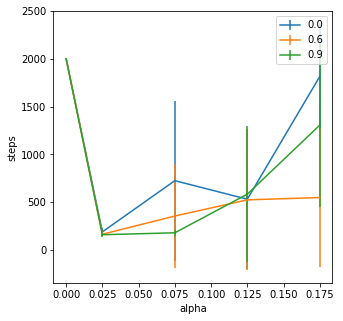

In [138]:
f, axes = plt.subplots(1, 1, figsize=(5, 5))

# plt.ylim(top=1) #ymax is your value
# plt.ylim(bottom=0) #ymin is your value
for i in range(0, len(lambdas), 1):
    means = np.mean(data5[i,:,:], axis  = 1)
    std = np.std(data5[i,:,:], axis  = 1)
    axes.errorbar(alphas, means, yerr=std)

axes.legend(lambdas)
axes.set_xlabel('alpha')
axes.set_ylabel('steps')
plt.show()

Observations: For very large and very small alphas, the performance is extremely bad.
variance in the last three graphs are higher because the number of episodes and the number of seeds are low.
There are not enough data to back up this conclusion but with more thorough experiments we could see that the higher the labmda gets, the more robust it becomes to change in alpha unless it gets too close to 1, and although the curves overlap in my experiments, with more data, higher lambdas should naturally take lower steps to finish and the best combination would be for high lambda and middle alphas.
To compare the graphs, we need to set the seeds before running each set of experiment, otherwise the comparison would be inaccurate.
The first three graphs are obtained while allowing the change in weights.
The last two graphs only use the weights after a certain number of episodes, the 4th one uses a epsilon greedy policy in the test and the last one uses a completely greedy policy for test.